In [7]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import torch
from torchvision import transforms
import random
from torch.utils.data import DataLoader
from dataset.dcase24 import get_training_set
from helpers.init import worker_init_fn

In [8]:
# mel = torchaudio.transforms.MelSpectrogram(
#     sample_rate=config.sample_rate,
#     n_fft=config.n_fft,
#     win_length=config.window_length,
#     hop_length=config.hop_length,
#     n_mels=config.n_mels,
#     f_min=config.f_min,
#     f_max=config.f_max
# )

Sample data at index 0: (tensor([[0.0187, 0.0170, 0.0219,  ..., 0.0534, 0.0484, 0.0344]]), 'audio/airport-lisbon-1000-40000-0-a.wav', tensor(0), np.int64(0), np.int64(2))
Unpacked values:
Audio: torch.Size([1, 44100])
File: audio/airport-lisbon-1000-40000-0-a.wav
Label: 0
Device: 0
City: 2


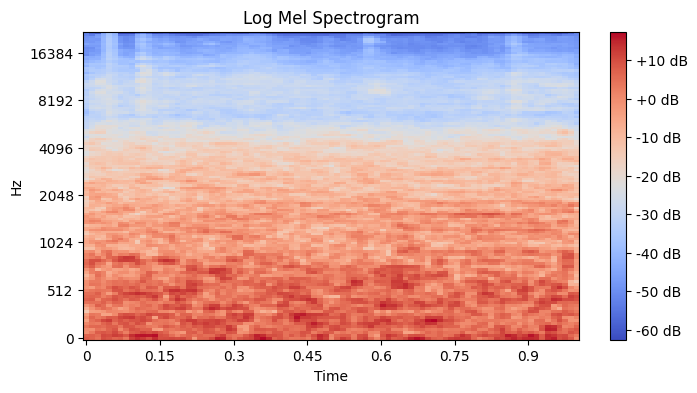

In [9]:
def visualize_log_mel_spectrogram(audio, mel_augment, config):
    """
    Visualizes the log Mel spectrogram of the audio sample.
    
    :param audio: The audio waveform as a numpy array.
    :param mel_augment: Augmentations to apply to the Mel spectrogram (if any).
    :param config: Configuration containing sample rate and number of Mel bins.
    """
    # Apply augmentations (if any)
    if mel_augment:
        audio = mel_augment(audio)  # Apply any augmentation if defined
    
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=config["sample_rate"], 
                                                     n_mels=config["n_mels"], 
                                                     hop_length=config["hop_length"])
    
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Plotting the spectrogram
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=config["sample_rate"], hop_length=config["hop_length"])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram')
    plt.show()

config = {
    # "sample_rate": 32000,
    "orig_sample_rate": 44100,  # Replace with your dataset's sample rate
    "roll_sec": 0.1,
    "sample_rate": 44100,
    "n_mels": 128,
    "hop_length": 512,
    "subset": 5, 
    "batch_size": 32,
}

# Augmentations
mel_augment = transforms.Compose([])  # Add your augmentations here

# Generate rolling parameters
roll_samples = config["orig_sample_rate"] * config["roll_sec"]

# Load the training dataset
train_dl = DataLoader(
    dataset=get_training_set(config["subset"], roll=roll_samples),
    worker_init_fn=worker_init_fn,
    batch_size=config["batch_size"],
    shuffle=True,
)

# Extract a sample for visualization
train_dataset = train_dl.dataset
sample_idx = 0  # Choose any index from the dataset
sample_data = train_dataset[sample_idx]  # Get the sample data

# Print the sample data to inspect the returned values
print(f"Sample data at index {sample_idx}: {sample_data}")

# Unpack the returned sample structure
audio, file, label, device, city = sample_data

# Print the unpacked values
print(f"Unpacked values:\nAudio: {audio.shape}\nFile: {file}\nLabel: {label}\nDevice: {device}\nCity: {city}")

# Convert to numpy if needed
if isinstance(audio, torch.Tensor):
    audio = audio.flatten().numpy()

# Visualize the sample
visualize_log_mel_spectrogram(audio, mel_augment, config)    

Sample data at index 0: (tensor([[0.0187, 0.0170, 0.0219,  ..., 0.0534, 0.0484, 0.0344]]), 'audio/airport-lisbon-1000-40000-0-a.wav', tensor(0), np.int64(0), np.int64(2))
Unpacked values:
Audio: torch.Size([1, 44100])
File: audio/airport-lisbon-1000-40000-0-a.wav
Label: 0
Device: 0
City: 2


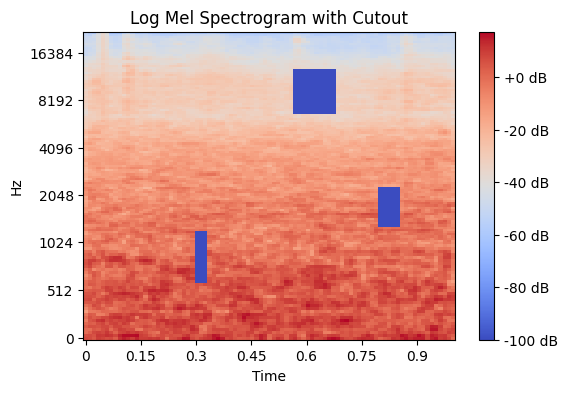

In [10]:
num_holes = 3
max_width = 10
max_height = 20

class Cutout:
    def __init__(self, num_holes=num_holes, max_width=max_width, max_height=max_height):
        """
        Cutout augmentation that masks out random rectangular regions in the spectrogram.
        
        Args:
            num_holes (int): Number of rectangular regions to mask.
            max_width (int): Maximum width of each masked region.
            max_height (int): Maximum height of each masked region.
        """
        self.num_holes = num_holes
        self.max_width = max_width
        self.max_height = max_height

    def __call__(self, spectrogram):
        # Make a copy so the original spectrogram is not modified.
        aug_spec = spectrogram.copy()
        freq_bins, time_steps = aug_spec.shape
        
        for _ in range(self.num_holes):
            # Randomly select the dimensions for the cutout region.
            hole_width = np.random.randint(1, self.max_width + 1)
            hole_height = np.random.randint(1, self.max_height + 1)
            
            # Randomly select the top-left corner for the cutout.
            x = np.random.randint(0, max(1, time_steps - hole_width))
            y = np.random.randint(0, max(1, freq_bins - hole_height))
            
            # Set the selected region to zero.
            aug_spec[y : y + hole_height, x : x + hole_width] = -100
        return aug_spec

# Create a transform pipeline that applies the Cutout augmentation.
mel_augment = transforms.Compose([
    Cutout(num_holes=num_holes, max_width=max_width, max_height=max_height)
])

def visualize_log_mel_spectrogram(audio, mel_augment, config):
    """
    Visualizes the original and augmented (with Cutout) log Mel spectrograms.
    
    :param audio: The audio waveform as a numpy array.
    :param mel_augment: Augmentation pipeline to apply to the log Mel spectrogram.
    :param config: Configuration dictionary containing sample_rate, n_mels, hop_length.
    """
    # Compute Mel spectrogram from the audio
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, 
        sr=config["sample_rate"], 
        n_mels=config["n_mels"], 
        hop_length=config["hop_length"]
    )
    
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    # Apply Cutout augmentation to the log Mel spectrogram
    log_mel_with_cutout = mel_augment(log_mel_spectrogram)

    # Plot the original and augmented spectrograms side by side
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(
        log_mel_with_cutout, 
        sr=config["sample_rate"], 
        hop_length=config["hop_length"], 
        x_axis='time', 
        y_axis='mel',
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram with Cutout')
    plt.show()

config = {
    # "sample_rate": 32000,
    "orig_sample_rate": 44100,  # Replace with your dataset's sample rate
    "roll_sec": 0.1,
    "sample_rate": 44100,
    "n_mels": 128,
    "hop_length": 512,
    "subset": 5, 
    "batch_size": 32,
}

# # Generate rolling parameters
# roll_samples = config["orig_sample_rate"] * config["roll_sec"]

# # Load the training dataset
# train_dl = DataLoader(
#     dataset=get_training_set(config["subset"], roll=roll_samples),
#     worker_init_fn=worker_init_fn,
#     batch_size=config["batch_size"],
#     shuffle=True,
# )

# # Extract a sample for visualization
# train_dataset = train_dl.dataset
# sample_idx = 0  # Choose any index from the dataset
# sample_data = train_dataset[sample_idx]  # Get the sample data

# Print the sample data to inspect the returned values
print(f"Sample data at index {sample_idx}: {sample_data}")

# Unpack the returned sample structure
audio, file, label, device, city = sample_data

# Print the unpacked values
print(f"Unpacked values:\nAudio: {audio.shape}\nFile: {file}\nLabel: {label}\nDevice: {device}\nCity: {city}")

# Convert to numpy if needed
if isinstance(audio, torch.Tensor):
    audio = audio.flatten().numpy()

# Visualize the log Mel spectrogram with and without the Cutout augmentation.
visualize_log_mel_spectrogram(audio, mel_augment, config)

Sample data at index 0: (tensor([[0.0187, 0.0170, 0.0219,  ..., 0.0534, 0.0484, 0.0344]]), 'audio/airport-lisbon-1000-40000-0-a.wav', tensor(0), np.int64(0), np.int64(2))
Unpacked values:
Audio: torch.Size([1, 44100])
File: audio/airport-lisbon-1000-40000-0-a.wav
Label: 0
Device: 0
City: 2


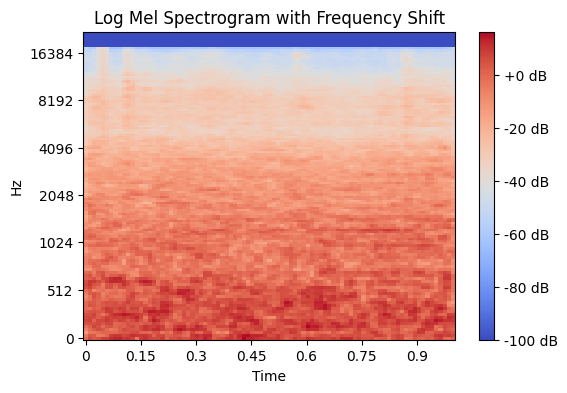

In [11]:
max_shift = 10
fill_value = -100.0

class RandomShiftUpDownNp:
    def __init__(self, max_shift=max_shift, fill_value=fill_value):
        """
        Randomly shift the log Mel spectrogram up or down along the frequency axis.

        Args:
            max_shift (int): Maximum number of Mel bins to shift up or down.
            fill_value (float): Value to pad with (typically -100 dB).
        """
        self.max_shift = max_shift
        self.fill_value = fill_value

    def __call__(self, spectrogram):
        # Copy the spectrogram so original is not modified
        shifted = np.full_like(spectrogram, self.fill_value)

        freq_bins, time_steps = spectrogram.shape
        shift = np.random.randint(-self.max_shift, self.max_shift + 1)

        if shift > 0:
            # Shift up (move rows downward)
            shifted[shift:] = spectrogram[:-shift]
        elif shift < 0:
            # Shift down (move rows upward)
            shifted[:shift] = spectrogram[-shift:]
        else:
            # No shift
            shifted = spectrogram.copy()

        return shifted
    
mel_augment = transforms.Compose([
    RandomShiftUpDownNp(max_shift=max_shift),
    # Cutout(),  # if you're chaining multiple augmentations
])

def visualize_log_mel_spectrogram(audio, mel_augment, config):
    """
    Visualizes the original and augmented (with Cutout) log Mel spectrograms.
    
    :param audio: The audio waveform as a numpy array.
    :param mel_augment: Augmentation pipeline to apply to the log Mel spectrogram.
    :param config: Configuration dictionary containing sample_rate, n_mels, hop_length.
    """
    # Compute Mel spectrogram from the audio
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, 
        sr=config["sample_rate"], 
        n_mels=config["n_mels"], 
        hop_length=config["hop_length"]
    )
    
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    # Apply Cutout augmentation to the log Mel spectrogram
    log_mel_with_freqshift = mel_augment(log_mel_spectrogram)

    # Plot the original and augmented spectrograms side by side
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(
        log_mel_with_freqshift, 
        sr=config["sample_rate"], 
        hop_length=config["hop_length"], 
        x_axis='time', 
        y_axis='mel',
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram with Frequency Shift')
    plt.show()

config = {
    # "sample_rate": 32000,
    "orig_sample_rate": 44100,  # Replace with your dataset's sample rate
    "roll_sec": 0.1,
    "sample_rate": 44100,
    "n_mels": 128,
    "hop_length": 512,
    "subset": 5, 
    "batch_size": 32,
}

# # Generate rolling parameters
# roll_samples = config["orig_sample_rate"] * config["roll_sec"]

# # Load the training dataset
# train_dl = DataLoader(
#     dataset=get_training_set(config["subset"], roll=roll_samples),
#     worker_init_fn=worker_init_fn,
#     batch_size=config["batch_size"],
#     shuffle=True,
# )

# # Extract a sample for visualization
# train_dataset = train_dl.dataset
# sample_idx = 0  # Choose any index from the dataset
# sample_data = train_dataset[sample_idx]  # Get the sample data

# Print the sample data to inspect the returned values
print(f"Sample data at index {sample_idx}: {sample_data}")

# Unpack the returned sample structure
audio, file, label, device, city = sample_data

# Print the unpacked values
print(f"Unpacked values:\nAudio: {audio.shape}\nFile: {file}\nLabel: {label}\nDevice: {device}\nCity: {city}")

# Convert to numpy if needed
if isinstance(audio, torch.Tensor):
    audio = audio.flatten().numpy()

# Visualize the log Mel spectrogram with and without the Cutout augmentation.
visualize_log_mel_spectrogram(audio, mel_augment, config)

Sample data at index 0: (tensor([[0.0187, 0.0170, 0.0219,  ..., 0.0534, 0.0484, 0.0344]]), 'audio/airport-lisbon-1000-40000-0-a.wav', tensor(0), np.int64(0), np.int64(2))
Unpacked values:
Audio: torch.Size([1, 44100])
File: audio/airport-lisbon-1000-40000-0-a.wav
Label: 0
Device: 0
City: 2


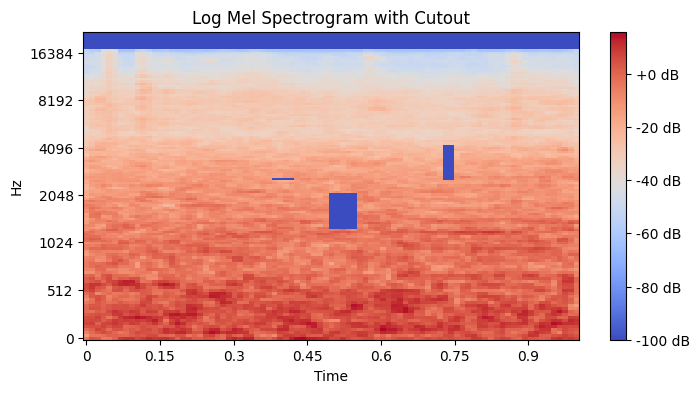

In [12]:
mel_augment = transforms.Compose([
    RandomShiftUpDownNp(max_shift=max_shift),
    Cutout(num_holes=num_holes, max_width=max_width, max_height=max_height)
])

def visualize_log_mel_spectrogram(audio, mel_augment, config):
    """
    Visualizes the original and augmented (with Cutout) log Mel spectrograms.
    
    :param audio: The audio waveform as a numpy array.
    :param mel_augment: Augmentation pipeline to apply to the log Mel spectrogram.
    :param config: Configuration dictionary containing sample_rate, n_mels, hop_length.
    """
    # Compute Mel spectrogram from the audio
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, 
        sr=config["sample_rate"], 
        n_mels=config["n_mels"], 
        hop_length=config["hop_length"]
    )
    
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    # Apply Cutout augmentation to the log Mel spectrogram
    log_mel_with_augment = mel_augment(log_mel_spectrogram)

    # Plot the original and augmented spectrograms side by side
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(
        log_mel_with_augment, 
        sr=config["sample_rate"], 
        hop_length=config["hop_length"], 
        x_axis='time', 
        y_axis='mel',
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram with Cutout')
    plt.show()

config = {
    # "sample_rate": 32000,
    "orig_sample_rate": 44100,  # Replace with your dataset's sample rate
    "roll_sec": 0.1,
    "sample_rate": 44100,
    "n_mels": 128,
    "hop_length": 512,
    "subset": 5, 
    "batch_size": 32,
}

# # Generate rolling parameters
# roll_samples = config["orig_sample_rate"] * config["roll_sec"]

# # Load the training dataset
# train_dl = DataLoader(
#     dataset=get_training_set(config["subset"], roll=roll_samples),
#     worker_init_fn=worker_init_fn,
#     batch_size=config["batch_size"],
#     shuffle=True,
# )

# # Extract a sample for visualization
# train_dataset = train_dl.dataset
# sample_idx = 0  # Choose any index from the dataset
# sample_data = train_dataset[sample_idx]  # Get the sample data

# Print the sample data to inspect the returned values
print(f"Sample data at index {sample_idx}: {sample_data}")

# Unpack the returned sample structure
audio, file, label, device, city = sample_data

# Print the unpacked values
print(f"Unpacked values:\nAudio: {audio.shape}\nFile: {file}\nLabel: {label}\nDevice: {device}\nCity: {city}")

# Convert to numpy if needed
if isinstance(audio, torch.Tensor):
    audio = audio.flatten().numpy()

# Visualize the log Mel spectrogram with and without the Cutout augmentation.
visualize_log_mel_spectrogram(audio, mel_augment, config)